In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import imageio.v2 as io
import cv2

from data_gen_intensity import *
from unet_model import *

Total intensity images: 2560
Train intensity images: 2304
Validation intensity images: 256
Test intensity images: 75
****************************************
Input image resolution: 16 x 1024 x 1
Output image resolution: 64 x 1024 x 1
Upscaling factor: x4
****************************************


### Configuración GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

#Hacer que tf vaya asignando solo la cantidad de memoria requerida
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Generación del dataset de entrenamiento y prueba

### Empleando generadores

(8, 16, 1024, 1)


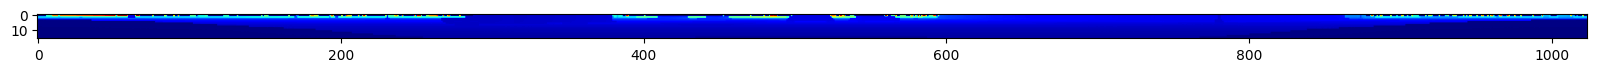

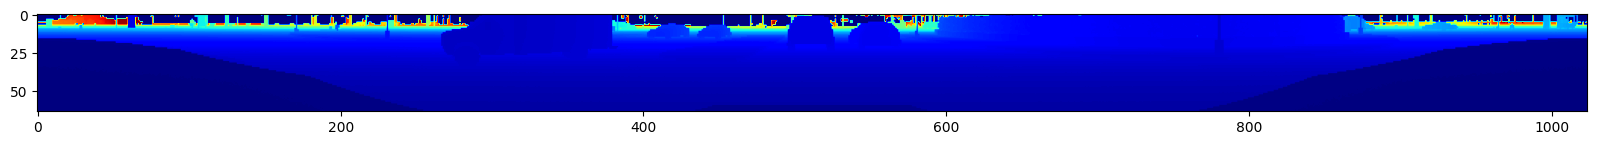

"\nfor a, b in test_dataset_example.take(1):\n    plt.figure(figsize=(20,20))\n    plt.imshow(a[0], cmap='jet')\n    plt.figure(figsize=(20,20))\n    plt.imshow(b[0], cmap='jet')\n    plt.show()"

In [3]:
batch_size=8

#Training dataset
train_dataset_example = tf.data.Dataset.from_generator(generator=train_data_generator, output_types=(tf.float32, tf.float32))
train_dataset_example = train_dataset_example.batch(batch_size)

#Validation dataset
valid_dataset_example = tf.data.Dataset.from_generator(generator=valid_data_generator, output_types=(tf.float32, tf.float32))
valid_dataset_example = valid_dataset_example.batch(batch_size)


for a, b in valid_dataset_example.take(1):
    print(a.shape)
    plt.figure(figsize=(20,20))
    plt.imshow(a[0], cmap='jet')
    plt.figure(figsize=(20,20))
    plt.imshow(b[0], cmap='jet')
    plt.show()

#Test dataset
#test_dataset_example = tf.data.Dataset.from_generator(generator=test_data_generator, output_types=(tf.float32, tf.float32))
#test_dataset_example = test_dataset_example.batch(batch_size)

## Modelo

In [2]:
model = Unet()
model.summary()

#from keras.utils.vis_utils import plot_model
#plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 1024, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 32, 1024, 64  640        ['input_1[0][0]']                
 ose)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 1024, 64  256        ['conv2d_transpose[0][0]']       
 alization)                     )                                                             

## Entrenamiento con generadores

In [3]:
def get_check_callback():
    path_check_folder = os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet\3_model_fit_keras\3.2_kitti_carla_v2_with_MC_dropout\model_intensity')
    path_csv_check = os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet\3_model_fit_keras\3.2_kitti_carla_v2_with_MC_dropout\model_intensity\csv_train.csv')
    #tensorboard_logs_folder = os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet_based\checkpoints3\tensorboard_logs')
   
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_check_folder,'best_{epoch:02d}_{val_loss:.4f}.h5'),#path_check_folder,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   verbose=0,
                                                                   mode='min',
                                                                   save_best_only=True)
    csv_logger = keras.callbacks.CSVLogger(path_csv_check)
    
    #tensorboard_model = keras.callbacks.TensorBoard(log_dir=tensorboard_logs_folder)
    #command = 'tensorboard --logdir=' + os.path.join(tensorboard_logs_folder, 'logs') + ' &'
    #os.system(command)     
    
    return model_checkpoint_callback, csv_logger#, tensorboard_model

epochs = 350
batch_size=16

def train():

    train_dataset = tf.data.Dataset.from_generator(generator=train_data_generator, output_types=(tf.float32, tf.float32))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.__iter__()

    valid_dataset = tf.data.Dataset.from_generator(generator=valid_data_generator, output_types=(tf.float32, tf.float32))
    valid_dataset = valid_dataset.batch(batch_size)
    valid_dataset = valid_dataset.__iter__()
    
    #model_checkpoint_callback, csv_logger, tensorboard_model = get_check_callback()
    model_checkpoint_callback, csv_logger = get_check_callback()

    model.fit(train_dataset,
              validation_data=valid_dataset,
              validation_steps=round(len(intensity_valid_urls)/batch_size),
              epochs=epochs,
              steps_per_epoch=round(len(intensity_train_urls)/batch_size),
              verbose=1,
              #callbacks=[model_checkpoint_callback, csv_logger, tensorboard_model])
              callbacks=[model_checkpoint_callback, csv_logger])

train()
model.save(os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet\3_model_fit_keras\3.2_kitti_carla_v2_with_MC_dropout\model_intensity\final.h5'))

Epoch 1/350
144/144 [==============================] - 126s 787ms/step - loss: 0.1713 - val_loss: 0.1567
Epoch 2/350
144/144 [==============================] - 112s 772ms/step - loss: 0.1149 - val_loss: 0.1482
Epoch 3/350
144/144 [==============================] - 115s 792ms/step - loss: 0.0991 - val_loss: 0.1288
Epoch 4/350
144/144 [==============================] - 112s 777ms/step - loss: 0.0886 - val_loss: 0.1080
Epoch 5/350
144/144 [==============================] - 113s 778ms/step - loss: 0.0813 - val_loss: 0.0730
Epoch 6/350
144/144 [==============================] - 109s 756ms/step - loss: 0.0743 - val_loss: 0.0781
Epoch 7/350
144/144 [==============================] - 108s 750ms/step - loss: 0.0693 - val_loss: 0.0691
Epoch 8/350
144/144 [==============================] - 109s 755ms/step - loss: 0.0643 - val_loss: 0.0627
Epoch 9/350
144/144 [==============================] - 110s 760ms/step - loss: 0.0616 - val_loss: 0.0529
Epoch 10/350
144/144 [==============================] -